In [1]:
!kaggle datasets download -d bittlingmayer/amazonreviews


Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown


In [6]:
import zipfile
import os

zip_path = "amazonreviews.zip"
extract_dir = "amazon_reviews"  # Folder to extract into

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the contents
print(os.listdir(extract_dir))


['test.ft.txt.bz2', 'train.ft.txt.bz2']


In [7]:
import bz2

input_path = 'amazon_reviews/train.ft.txt.bz2'
output_path = 'amazon_reviews/train.ft.txt'

with bz2.open(input_path, 'rb') as file_in, open(output_path, 'wb') as file_out:
    file_out.write(file_in.read())

print("✅ train.ft.txt extracted.")


✅ train.ft.txt extracted.


In [8]:
input_path = 'amazon_reviews/test.ft.txt.bz2'
output_path = 'amazon_reviews/test.ft.txt'

with bz2.open(input_path, 'rb') as file_in, open(output_path, 'wb') as file_out:
    file_out.write(file_in.read())

print("✅ test.ft.txt extracted.")


✅ test.ft.txt extracted.


In [1]:
import pandas as pd

def load_review_data(path, n=5000):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i>=n:
                break
            label, text = line.strip().split(' ',1)
            sentiment = 'positive' if label == '__label__2' else 'negative'
            data.append((sentiment,text))
    return pd.DataFrame(data, columns=['sentiment','review'])

df = load_review_data('amazon_reviews/train.ft.txt', 5000)
df.head(25)
            

,sentiment,review
0,positive,Stuning even for the non-gamer: This sound tra...
1,positive,The best soundtrack ever to anything.: I'm rea...
2,positive,Amazing!: This soundtrack is my favorite music...
3,positive,Excellent Soundtrack: I truly like this soundt...
4,positive,"Remember, Pull Your Jaw Off The Floor After He..."
5,positive,an absolute masterpiece: I am quite sure any o...
6,negative,"Buyer beware: This is a self-published book, a..."
7,positive,Glorious story: I loved Whisper of the wicked ...
8,positive,A FIVE STAR BOOK: I just finished reading Whis...
9,positive,Whispers of the Wicked Saints: This was a easy...


In [12]:
!pip install transformers torch --quiet


In [2]:
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_model = pipeline("sentiment-analysis")

# Test it works
sentiment_model("I absolutely love this product!")


C:\Users\DGV07\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998854398727417}]

In [3]:
# Limit to 100 to avoid long processing time initially
sample_df = df.head(100).copy()

# Apply model and get predictions
predictions = sentiment_model(sample_df['review'].tolist())

# Extract just the label (POSITIVE/NEGATIVE)
sample_df['predicted_sentiment'] = [p['label'].lower() for p in predictions]

# Compare results
sample_df[['review', 'sentiment', 'predicted_sentiment']].head()


,review,sentiment,predicted_sentiment
0,Stuning even for the non-gamer: This sound tra...,positive,positive
1,The best soundtrack ever to anything.: I'm rea...,positive,positive
2,Amazing!: This soundtrack is my favorite music...,positive,positive
3,Excellent Soundtrack: I truly like this soundt...,positive,positive
4,"Remember, Pull Your Jaw Off The Floor After He...",positive,positive


In [4]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(sample_df['sentiment'], sample_df['predicted_sentiment'])
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 92.00%


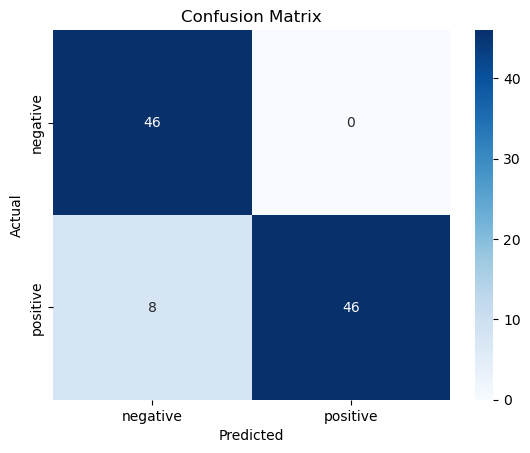

              precision    recall  f1-score   support

    negative       0.85      1.00      0.92        46
    positive       1.00      0.85      0.92        54

    accuracy                           0.92       100
   macro avg       0.93      0.93      0.92       100
weighted avg       0.93      0.92      0.92       100



In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(sample_df['sentiment'], sample_df['predicted_sentiment'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(sample_df['sentiment'], sample_df['predicted_sentiment']))


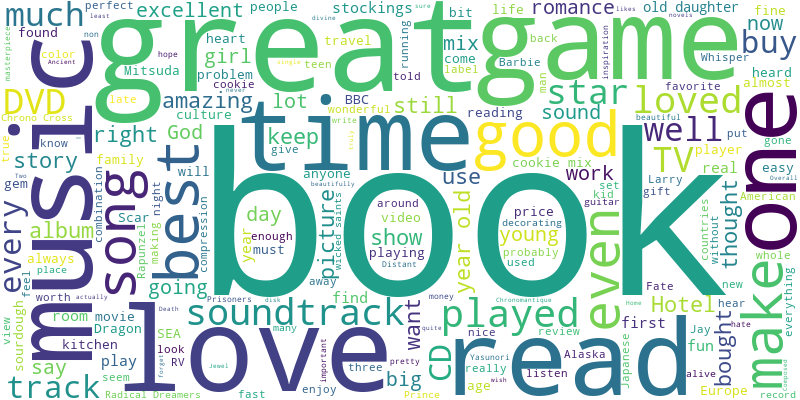

In [6]:
from wordcloud import WordCloud

# Join all reviews with predicted sentiment
positive_reviews = " ".join(sample_df[sample_df['predicted_sentiment'] == 'positive']['review'])
negative_reviews = " ".join(sample_df[sample_df['predicted_sentiment'] == 'negative']['review'])

# Positive WordCloud
WordCloud(width=800, height=400, background_color='white').generate(positive_reviews).to_image()


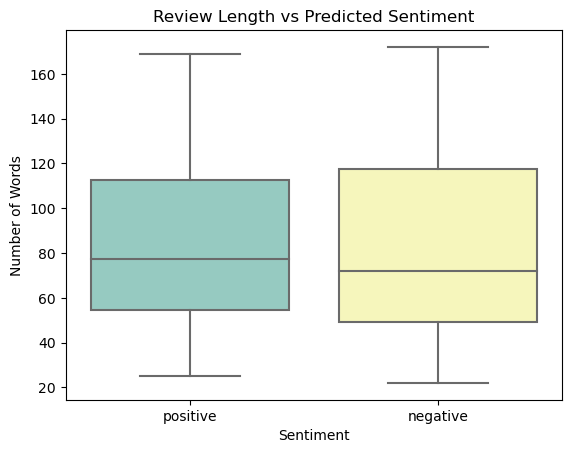

In [7]:
sample_df['review_length'] = sample_df['review'].apply(lambda x: len(x.split()))

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=sample_df, x='predicted_sentiment', y='review_length',palette='Set3')
plt.title("Review Length vs Predicted Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()

In [12]:
def detect_generic_review(text):
    generic_words = ['amazing', 'awesome', 'great', 'nice', 'good', 'bad', 'okay', 'love', 'hate']
    word_count = len(text.split())
    exclamations = text.count('!')
    generic_score = sum(1 for word in generic_words if word in text.lower())
    
    return word_count < 5 or generic_score >= 3 or exclamations > 3

In [13]:
sample_df['is_generic'] = sample_df['review'].apply(detect_generic_review)

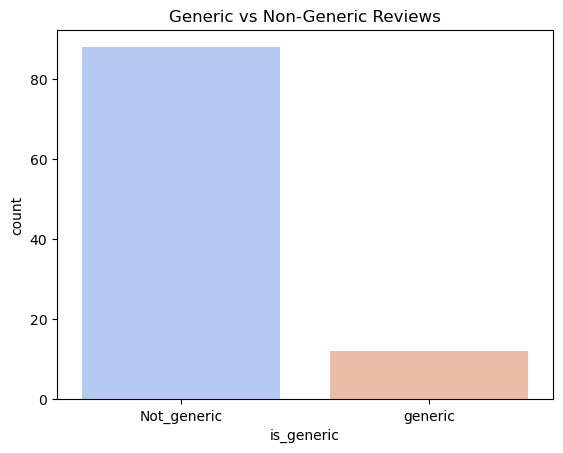

In [16]:
sns.countplot(data=sample_df, x='is_generic', palette='coolwarm')
plt.xticks([0,1],['Not_generic','generic'])
plt.title("Generic vs Non-Generic Reviews")
plt.show()

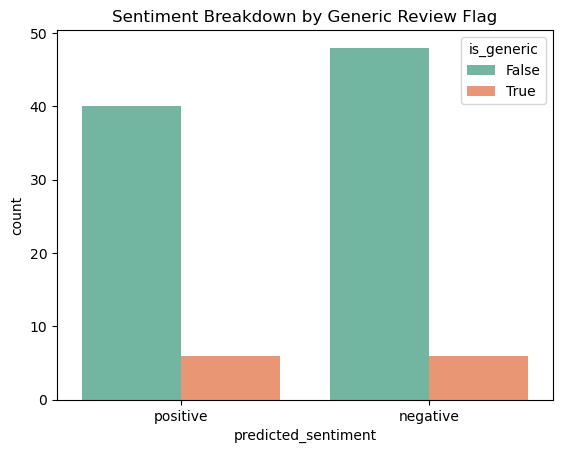

In [17]:
#Do generic reviews tend to be positive or negative?
sns.countplot(data=sample_df, x='predicted_sentiment', hue='is_generic', palette='Set2')
plt.title("Sentiment Breakdown by Generic Review Flag")
plt.show()

In [21]:
positive_words = ['love', 'excellent', 'perfect', 'best', 'amazing', 'great', 'good', 'wonderful']
negative_words = ['bad', 'terrible', 'worst', 'poor', 'hate', 'awful', 'disappointed', 'boring']

def rule_sentiment(text):
    text = text.lower()
    pos_count = sum(word in text for word in positive_words)
    neg_count = sum(word in text for word in negative_words)
    
    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

In [22]:
sample_df['rule_sentiment'] = sample_df['review'].apply(rule_sentiment)

In [23]:
sample_df.head(20)

,sentiment,review,predicted_sentiment,review_length,is_generic,rule_sentiment
0,positive,Stuning even for the non-gamer: This sound tra...,positive,80,True,neutral
1,positive,The best soundtrack ever to anything.: I'm rea...,positive,97,False,positive
2,positive,Amazing!: This soundtrack is my favorite music...,positive,129,False,positive
3,positive,Excellent Soundtrack: I truly like this soundt...,positive,118,False,positive
4,positive,"Remember, Pull Your Jaw Off The Floor After He...",positive,87,False,positive
5,positive,an absolute masterpiece: I am quite sure any o...,positive,142,False,positive
6,negative,"Buyer beware: This is a self-published book, a...",negative,139,False,negative
7,positive,Glorious story: I loved Whisper of the wicked ...,positive,105,False,positive
8,positive,A FIVE STAR BOOK: I just finished reading Whis...,positive,103,False,positive
9,positive,Whispers of the Wicked Saints: This was a easy...,positive,63,False,neutral


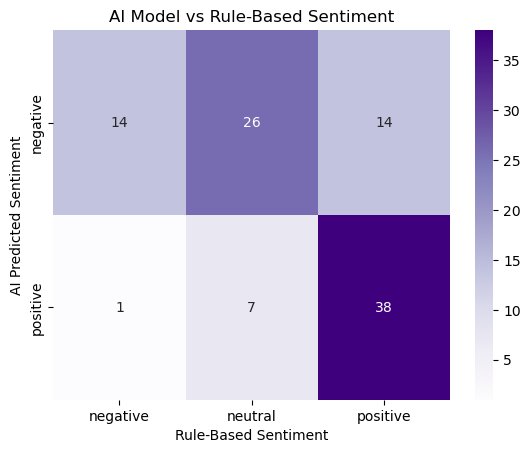

In [26]:
sns.heatmap(pd.crosstab(sample_df['predicted_sentiment'], sample_df['rule_sentiment']), annot=True, fmt='d', cmap='Purples')
plt.title("AI Model vs Rule-Based Sentiment")
plt.xlabel("Rule-Based Sentiment")
plt.ylabel("AI Predicted Sentiment")
plt.show()